#1. SVM in sklearn

Multi-class SVM using sklearn is done in this part for the IRIS dataset. The effect of SVM ragularization parameter (C) and gamma is compared for rbf kernel using a grid search.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [0]:
# Dataset for grid search
iris = load_iris()
X = iris.data[:, :2]
y = iris.target
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)


# Training and getting the best parameters
C_range = np.array([0.1, 1, 10, 100, 1000])  # range for parameter C
gamma_range = np.array([0.001, 0.01, 0.1, 0.3, 0.5, 0.8, 1])  # range for parameter Gamma

param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(test_size=0.2, random_state=42)
grid = GridSearchCV(estimator=SVC(), param_grid=param_grid, cv=cv)
grid.fit(X_train, y_train)
print("The best parameters from Training are %s with a score of %0.4f"
      % (grid.best_params_, grid.best_score_))

The best parameters from Training are {'C': 10.0, 'gamma': 0.01} with a score of 0.8542


Gained the same test accuracy from my code and the SVM function in sklearn.

In [0]:
# Validating on test data using the best parameters
print('Training Accuracy = ', grid.score(X_train, y_train))
Test_acc = SVC(C=10, kernel='rbf', gamma=0.1).fit(X_train, y_train).score(X_test, y_test)
print('Test Accuracy from scratch 0.1 = ', Test_acc)

Training Accuracy =  0.85
Test Accuracy from scratch 0.1 =  0.7333333333333333


Generated heatmaps for the grid of values assigned for two parameters.

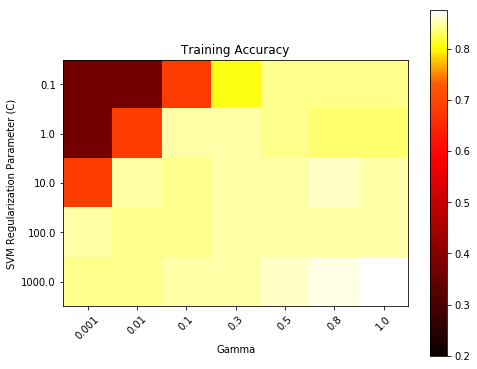

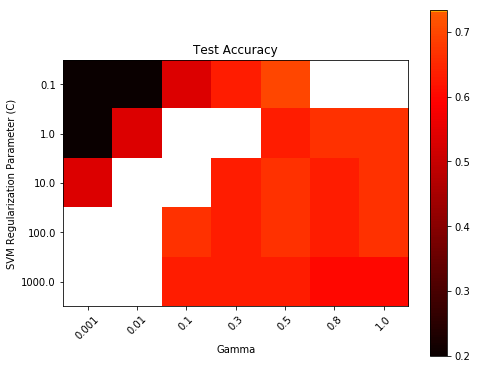

In [0]:
# Utility function to move the midpoint of a colormap to be around
# the values of interest.
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))


train_scores = np.zeros((5,7))
test_scores = np.zeros((5,7))
for c in range(len(C_range)):
    for gamma in range(len(gamma_range)):
        svc = SVC(C=C_range[c], gamma=gamma_range[gamma], kernel='rbf')
        svc.fit(X_train, y_train)
        train_scores[c, gamma] = svc.score(X_train, y_train)
        test_scores[c, gamma] = svc.score(X_test, y_test)


# Heatmap for Training Accuracy
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(train_scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.732))
plt.xlabel('Gamma')
plt.ylabel('SVM Regularization Parameter (C)')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Training Accuracy')
plt.show()


# Heatmap for Test Accuracy
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(test_scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.732))
plt.xlabel('Gamma')
plt.ylabel('SVM Regularization Parameter (C)')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Test Accuracy')
plt.show()

# 2. CIFAR-10 using sklearn

in this part, a BoVW (Bag of Visual Words) model is built, and used sklearn 's SVM classifier for classification.

First, we import the CIFAR dataset.

In [0]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Using TensorFlow backend.


170500096/170498071 [==============================] - 4s 0us/step




1.   After creating the training and test datasets, they are converted to grayscale.
2.   Then, the SIFT features are extracted using *cv2.xfeatures2d.SIFT_create()*.
1.   Those features are then clustered to 50 centers using k-means clustering
2.   Created and trained the model using above parameters.





In [0]:
import cv2
import numpy as np
from sklearn import svm
from sklearn.cluster import KMeans
from keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# bag of words to identify clusters
N = 1000
sift_features = np.empty(shape=(0, 128))
for img in X_train[:N, :, :, :]:
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Convert to grayscale
    extractor = cv2.xfeatures2d.SIFT_create()
    kp, des = extractor.detectAndCompute(gray_img, None) # Key points and Descriptors
    if des is None:
        continue
    assert des.shape[1] == 128, 'wrong shape'
    sift_features = np.concatenate([sift_features, des], axis=0)

# kmeans clustering
k_means = KMeans(n_clusters=50, random_state=0).fit(sift_features)

# prepare train data
feature_vectors = np.zeros(shape=(N, 50))
for i, img in enumerate(X_train[:N, :, :, :]):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    extractor = cv2.xfeatures2d.SIFT_create()
    kp, des = extractor.detectAndCompute(gray, None)
    if des is None:
        continue
    hist = k_means.predict(des)
    for val in hist:
        feature_vectors[i][val] += 1

# prepare test data
test_vectors = np.zeros(shape=(N, 50))
for i, img in enumerate(X_test[:N, :, :, :]):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    extractor = cv2.xfeatures2d.SIFT_create()
    kp, des = extractor.detectAndCompute(gray, None)
    if des is None:
        continue
    hist = k_means.predict(des)
    for val in hist:
        test_vectors[i][val] += 1

# run experiment
labels = y_train[:N, 0]
test_labels = y_test[:N, 0]
model = svm.SVC(
                kernel='rbf',
                C=10,
                gamma=0.01
            )
model = model.fit(feature_vectors, labels)

train_accuracy = model.score(feature_vectors, labels)
test_accuracy = model.score(test_vectors, test_labels)
print("train_accuracy: {} \n test_accuracy: {}".format(train_accuracy, test_accuracy))

A very low train and test accuracy were encountered when the dataset was scaled prior finding the SIFT features.

Training Acc = 57.2%
Test Acc = 21.4%

# 3. CVXOPT

Function *qp* is an interface for quadratic programs. *cvxopt.solvers.qp()* solves the pair of primal and dual convex quadratic programs. More details are illustrated in the report.

In [0]:
import cvxopt
import cvxopt.solvers
import numpy as np
from numpy import linalg
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


def linear_kernel(x1, x2, _=None):
    return np.dot(x1, x2)


def polynomial_kernel(x, y, p=3):
    return (1 + np.dot(x, y)) ** p


def rbf_kernel(x, y, gamma=0.01):
    return np.exp((-linalg.norm(x - y) ** 2) * gamma)


KERNEL_DICT = {
    "linear": linear_kernel,
    "poly": polynomial_kernel,
    "rbf": rbf_kernel
}


class SVM(object):

    def __init__(self, kernel='rbf', c=None, param=None, verbose=False):
        """
        Initialize SVM Object
        :param kernel:          str (linear / poly / rbf)
        :param c:               regularization term
        :param verbose:         print to console
        :param param:           gamma / polynomial degree parameter
        """
        self.kernel = KERNEL_DICT[kernel]
        self.C = c
        self.param = param
        self.verbose = verbose
        if not verbose:
            cvxopt.solvers.options['show_progress'] = False

        self.a = None
        self.sv = None
        self.sv_y = None
        self.w = None
        self.b = None

    def fit(self, x, y):
        """
        Fitting function
        :param x:       array of shape (num_examples, num_dims)
        :param y:       array of shape (num_examples, )
        :return:        No return
        """
        n_samples, n_features = x.shape

        # Gram matrix
        k_mat = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                k_mat[i, j] = self.kernel(x[i], x[j], self.param)

        _P = cvxopt.matrix(np.outer(y, y) * k_mat)
        _q = cvxopt.matrix(np.ones(n_samples) * -1)
        _A = cvxopt.matrix(y, (1, n_samples), tc='d')
        _b = cvxopt.matrix(0.0)

        if self.C is None:
            _G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            _h = cvxopt.matrix(np.zeros(n_samples))
        else:
            tmp1 = - np.identity(n_samples)
            tmp2 = np.identity(n_samples)
            _G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            _h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        # solve QP problem
        solution = cvxopt.solvers.qp(_P, _q, _G, _h, _A, _b)

        # Lagrange multipliers
        a = np.ravel(solution['x'])

        # Support vectors have non zero lagrange multipliers
        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = x[sv]
        self.sv_y = y[sv]
        if self.verbose:
            print("%d support vectors out of %d points" % (len(self.a), n_samples))

        # Intercept
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * k_mat[ind[n], sv])
        self.b /= len(self.a)

        # Weight vector
        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for n in range(len(self.a)):
                self.w += self.a[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w = None

    def project(self, x):
        """
        Helper for predict. Same input as predict.
        :param x:       array of shape (num_examples, num_dims)
        :return:        array of shape (num_examples, )
        """
        if self.w is not None:
            return np.dot(x, self.w) + self.b
        else:
            y_predict = np.zeros(len(x))
            for i in range(len(x)):
                s = 0
                for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                    s += a * sv_y * self.kernel(x[i], sv)
                y_predict[i] = s
            return y_predict + self.b

    def predict(self, x):
        """
        Predict function
        :param x:       array of shape (num_examples, num_dims)
        :return:        array of shape (num_examples, )
        """
        return np.sign(self.project(x))


class MultiClassSVM:

    def __init__(self, kernel='rbf', c=None, param=None, verbose=False):
        """
        Initialize SVM Object
        :param kernel:          str (linear / poly / rbf)
        :param c:               regularization term
        :param param:           gamma / polynomial degree parameter
        """
        self.kernel = kernel
        self.C = c
        self.param = param
        self.verbose = verbose
        self.classifiers = []
        self.classes = None

    def fit(self, x, y):
        """

        :param x:       array of shape (num_examples, num_dims)
        :param y:       array of shape (num_examples, )
        :return:        No return
        """
        self.classes = np.unique(y)
        for class_id in self.classes:
            classifier = SVM(kernel=self.kernel, c=self.C, param=self.param, verbose=self.verbose)
            y_ = ((y == class_id).astype(float) - 0.5) * 2
            classifier.fit(x, y_)
            self.classifiers.append(classifier)

    def predict(self, x):
        """
        Predict function
        :param x:       array of shape (num_examples, num_dims)
        :return:        array of shape (num_examples, )
        """
        assert len(self.classifiers) > 0, "run fit before prediction"
        scores = np.empty(shape=(x.shape[0], len(self.classifiers)))  # num_examples, num_classes
        for i, classifier in enumerate(self.classifiers):
            score = classifier.project(x)
            scores[:, i] = score
        return np.argmax(scores, axis=1)

Now, lets play with iris dataset (first two features).

In [0]:
iris = datasets.load_iris()
X = iris.data[:, :2]
Y = iris.target

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0, shuffle=True)

clf = MultiClassSVM(c=10, param=0.01)
clf.fit(x_train, y_train)
train_pred = clf.predict(x_train)
test_pred = clf.predict(x_test)

train_acc = accuracy_score(y_true=y_train, y_pred=train_pred)
test_acc = accuracy_score(y_true=y_test, y_pred=test_pred)

print("train_accuracy: {} \n test_accuracy: {}".format(train_acc, test_acc))

train_accuracy: 0.825 
 test_accuracy: 0.7


In part 1 we got a training accuracy of 0.8583 and a test accuracy of 0.7333. Considerably similar results are obtained in question 3 using convex optimization (cvxopt).

# 4. Two-Layer NN on TenforFlow

A two-layer Neural Network on using TensorFlow.

In [0]:
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten

batch_size = 32
num_classes = 10
epochs = 10

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)

y_test = keras.utils.to_categorical(y_test, num_classes)
model = Sequential()
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255 # scaling
x_test /= 255

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), shuffle=True)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss: ', scores[0])
print('Test accuracy: ', scores[1])

x_train shape:  (50000, 32, 32, 3)
50000 train samples
10000 test samples
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 9s 178us/step - loss: 1.8744 - acc: 0.3304 - val_loss: 1.7383 - val_acc: 0.3692
Epoch 2/10
50000/50000 [==============================] - 6s 126us/step - loss: 1.6885 - acc: 0.4006 - val_loss: 1.7422 - val_acc: 0.3900
Epoch 3/10
50000/50000 [==============================] - 6s 126us/step - loss: 1.6078 - acc: 0.4323 - val_loss: 1.5821 - val_acc: 0.4440
Epoch 4/10
50000/50000 [==============================] - 6s 125us/step - loss: 1.5542 - acc: 0.4535 - val_loss: 1.6157 - val_acc: 0.4246
Epoch 5/10
50000/50000 [==============================] - 7s 133us/step - loss: 1.5073 - acc: 0.4692 - val_loss: 1.6779 - val_acc: 0.3868
Epoch 6/10
50000/50000 [==============================] - 7s 141us